In [2]:
# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.firefox.service import Service
# from webdriver_manager.firefox import GeckoDriverManager
# import pandas as pd
# import time

# options = webdriver.FirefoxOptions()
# options.headless = True 
# driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)

# base_urls = {
#     2024: 'https://www.worldaquatics.com/competitions/2969/world-aquatics-championships-doha-2024/results?disciplines=WP&event=34b5b78f-a3a8-460d-b237-8e52ef04400c',
#     2023: 'https://www.worldaquatics.com/competitions/1/world-aquatics-championships-fukuoka-2023/results?disciplines=WP&event=d9520952-dcb7-4743-bc3e-4fe1fa05a8c2',
#     2022: 'https://www.worldaquatics.com/competitions/2902/19th-fina-world-championships-budapest-2022/results?disciplines=WP&event=b548c9eb-a01e-416e-b408-21072746bffc',
#     2021: 'https://www.worldaquatics.com/competitions/2409/fina-men-s-water-polo-world-league-super-final-2021/results?event=8d293c9f-7b1e-42bd-807b-ea17bfd3a322'
# }

# rounds = [
#     'finals', 'semifinals', 'quarterfinals', 'classification', 'round-of-16', 
#     'group-a', 'group-b', 'group-c', 'group-d'
# ]

# def scrape_data(url, year, round):
#     driver.get(url)
#     time.sleep(5)  
#     results = []
#     rows = driver.find_elements(By.CSS_SELECTOR, 'tr.results-table__row')
#     for row in rows:
#         cells = row.find_elements(By.CSS_SELECTOR, 'td')
#         if len(cells) > 6:
#             match_info = cells[1].text
#             date_time = cells[2].text + ' ' + cells[3].text
#             countries = ' vs '.join([div.text for div in cells[4].find_elements(By.CSS_SELECTOR, 'div.results-table__country')])
#             scores = ' '.join([span.text for span in cells[5].find_elements(By.CSS_SELECTOR, 'span.results-table__score')])
#             final_score = cells[7].text
#             results.append({
#                 'Year': year,
#                 'Round': round,
#                 'Match Info': match_info,
#                 'Date Time': date_time,
#                 'Countries': countries,
#                 'Scores by Quarter': scores,
#                 'Final Score': final_score
#             })
#     return results

# all_data = []
# for year, base_url in base_urls.items():
#     for round in rounds:
#         full_url = f'{base_url}&unit={round}'
#         try:
#             data = scrape_data(full_url, year, round)
#             all_data.extend(data)
#         except Exception as e:
#             print(f"Error scraping {full_url}: {e}")

# df = pd.DataFrame(all_data)
# df.to_csv('water_polo_results_selenium.csv', index=False)

# driver.quit()

# print('Data scraping complete and saved to water_polo_results_selenium.csv.')


In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('water_polo_results_selenium.csv')
df

,Year,Round,Match Info,Date Time,Countries,Scores by Quarter,Final Score
0,2024,finals,Men's Placement Match 3/4\nOFFICIAL,2/17/2024 3:30,Spain vs France,4 1 5 3 2 2 3 4,14\n10
1,2024,finals,Men's Final Match 48\nOFFICIAL,2/17/2024 9:30,Italy vs Croatia,3 2 2 3 2 3 4 3,13\n15
2,2024,semifinals,Men's Semi Final Match 43\nOFFICIAL,2/15/2024 8:00,Spain vs Italy,1 1 1 3 1 2 3 2,6\n8
3,2024,semifinals,Men's Semi Final Match 44\nOFFICIAL,2/15/2024 9:30,Croatia vs France,3 2 3 3 3 1 2 5,17\n16
4,2024,quarterfinals,Men's Quarter Final Round Match 35\nOFFICIAL,2/13/2024 8:00,Spain vs Montenegro,5 2 3 5 5 0 2 5,15\n12
...,...,...,...,...,...,...,...
142,2021,group-b,Group B Match 2\nOFFICIAL,6/26/2021 8:30,Japan vs Georgia,3 3 2 4 6 5 1 1,12\n13
143,2021,group-b,Group A Match 3\nOFFICIAL,6/27/2021 8:30,Georgia vs Montenegro,2 8 4 6 1 3 1 2,8\n19
144,2021,group-b,Group B Match 4\nOFFICIAL,6/27/2021 12:00,Japan vs United States of America,2 3 2 4 2 3 1 5,7\n15
145,2021,group-b,Group B Match 6\nOFFICIAL,6/28/2021 8:30,United States of America vs Georgia,3 1 5 2 2 3 3 3,13\n9


In [5]:
def team_split(s):
    s=str(s)
    spl=s.split(' vs ')
    return spl[0], spl[1]

def score_split(s):
    s=str(s)
    spl=s.split('\n')
    return spl[0], spl[1]

def querter_split(s):
    s=str(s)
    spl=s.split(' ')
    return spl[0]+spl[2]+spl[4]+spl[6],spl[1]+spl[3]+spl[5]+spl[7]

In [6]:

df['Team1'], df['Team2'] = zip(*df['Countries'].map(team_split))
df['Score1'], df['Score2'] = zip(*df['Final Score'].map(score_split))

df['weight']=0

for i in range(len(df)):
    if int(df['Score1'][i])>int(df['Score2'][i]):
        df['weight'][i]=1+np.log(int(df['Score1'][i])-int(df['Score2'][i])/int(df['Score1'][i]) )
    else:
        df['weight'][i]=1+np.log(int(df['Score2'][i])-int(df['Score1'][i])/int(df['Score2'][i]) )


C:\Users\leona\AppData\Local\Temp\ipykernel_7676\337409906.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'][i]=1+np.log(int(df['Score1'][i])-int(df['Score2'][i])/int(df['Score1'][i]) )


In [7]:
df

,Year,Round,Match Info,Date Time,Countries,Scores by Quarter,Final Score,Team1,Team2,Score1,Score2,weight
0,2024,finals,Men's Placement Match 3/4\nOFFICIAL,2/17/2024 3:30,Spain vs France,4 1 5 3 2 2 3 4,14\n10,Spain,France,14,10,3.586689
1,2024,finals,Men's Final Match 48\nOFFICIAL,2/17/2024 9:30,Italy vs Croatia,3 2 2 3 2 3 4 3,13\n15,Italy,Croatia,13,15,3.648536
2,2024,semifinals,Men's Semi Final Match 43\nOFFICIAL,2/15/2024 8:00,Spain vs Italy,1 1 1 3 1 2 3 2,6\n8,Spain,Italy,6,8,2.981001
3,2024,semifinals,Men's Semi Final Match 44\nOFFICIAL,2/15/2024 9:30,Croatia vs France,3 2 3 3 3 1 2 5,17\n16,Croatia,France,17,16,3.776258
4,2024,quarterfinals,Men's Quarter Final Round Match 35\nOFFICIAL,2/13/2024 8:00,Spain vs Montenegro,5 2 3 5 5 0 2 5,15\n12,Spain,Montenegro,15,12,3.653242
...,...,...,...,...,...,...,...,...,...,...,...,...
142,2021,group-b,Group B Match 2\nOFFICIAL,6/26/2021 8:30,Japan vs Georgia,3 3 2 4 6 5 1 1,12\n13,Japan,Georgia,12,13,3.491296
143,2021,group-b,Group A Match 3\nOFFICIAL,6/27/2021 8:30,Georgia vs Montenegro,2 8 4 6 1 3 1 2,8\n19,Georgia,Montenegro,8,19,3.922029
144,2021,group-b,Group B Match 4\nOFFICIAL,6/27/2021 12:00,Japan vs United States of America,2 3 2 4 2 3 1 5,7\n15,Japan,United States of America,7,15,3.676445
145,2021,group-b,Group B Match 6\nOFFICIAL,6/28/2021 8:30,United States of America vs Georgia,3 1 5 2 2 3 3 3,13\n9,United States of America,Georgia,13,9,3.510224


In [8]:
teams=df['Team1'].unique()

C:\Users\leona\AppData\Local\Temp\ipykernel_7676\3866552297.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  games = games.append({'TeamA':teamA,'TeamB':teamB,'Games':gamesA},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7676\3866552297.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  games = games.append({'TeamA':teamB,'TeamB':teamA,'Games':gamesA},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7676\3866552297.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  games = games.append({'TeamA':teamA,'TeamB':teamB,'Games':gamesA},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7676\3866552297.py:15: FutureWarning: The frame.append method is deprecated and will be removed

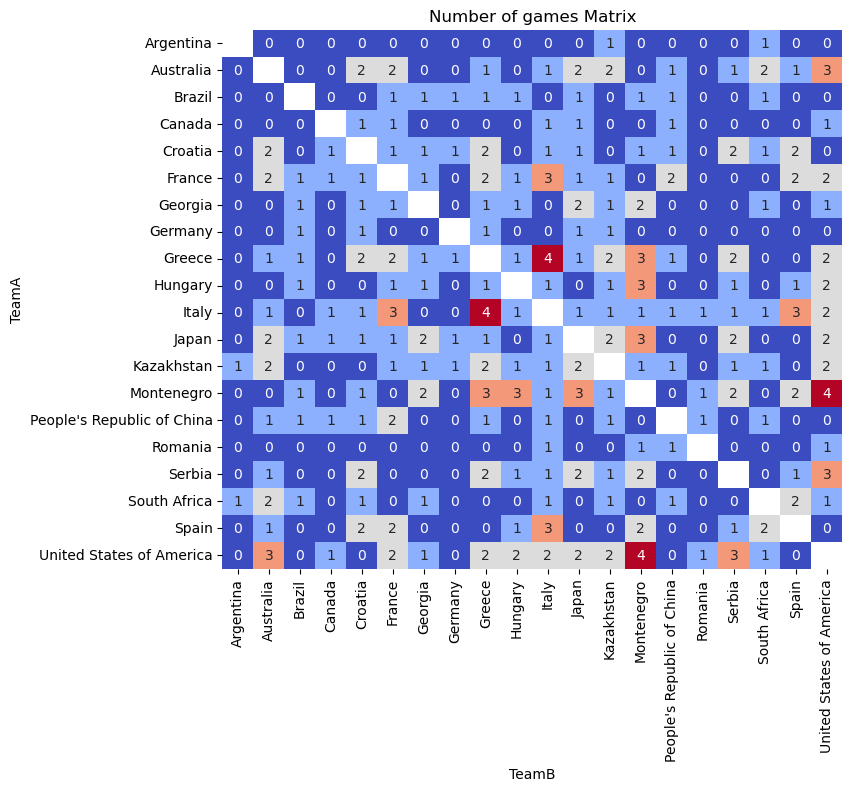

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

games = pd.DataFrame(columns=['TeamA','TeamB','Games'])

for i in range(len(teams)):
    for j in range(len(teams)):
        if i==j :
            continue
        teamA = teams[i]
        teamB = teams[j]
        gamesA = df[((df['Team1']==teamA) & (df['Team2']==teamB))|((df['Team1']==teamB) & (df['Team2']==teamA))]
        gamesA = len(gamesA)
        games = games.append({'TeamA':teamA,'TeamB':teamB,'Games':gamesA},ignore_index=True)
        games = games.append({'TeamA':teamB,'TeamB':teamA,'Games':gamesA},ignore_index=True)

games_matrix = pd.pivot_table(games, values='Games', index='TeamA', columns='TeamB')
plt.figure(figsize=(8, 7))
sns.heatmap(games_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Number of games Matrix')
plt.show()



In [10]:
teams = df['Team1'].unique()

probs = pd.DataFrame(columns=['TeamA','TeamB','Prob'])

for i in range(len(teams)):
    for j in range(i+1,len(teams)):
        teamA = teams[i]
        teamB = teams[j]

        if len(df[((df['Team1']==teamA) & (df['Team2']==teamB))|((df['Team1']==teamB) & (df['Team2']==teamA))])==0:
            continue

        
        gamesA = df[ ((df['Team1']==teamA) | (df['Team2']==teamA)) & (df['Score1']>df['Score2'])]
        gamesB = df[ ((df['Team1']==teamB) | (df['Team2']==teamB)) & (df['Score1']<df['Score2'])]
        gamesA = gamesA['weight'].sum()
        gamesB = gamesB['weight'].sum()
        if gamesA+gamesB<1e-7:
            probs=0.5
        else:
            prob = gamesA/(gamesA+gamesB)
        probs = probs.append({'TeamA':teamA,'TeamB':teamB,'Prob':prob},ignore_index=True)
        probs = probs.append({'TeamA':teamB,'TeamB':teamA,'Prob':1-prob},ignore_index=True)

probs


C:\Users\leona\AppData\Local\Temp\ipykernel_7676\1745014825.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append({'TeamA':teamA,'TeamB':teamB,'Prob':prob},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7676\1745014825.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append({'TeamA':teamB,'TeamB':teamA,'Prob':1-prob},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7676\1745014825.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append({'TeamA':teamA,'TeamB':teamB,'Prob':prob},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7676\1745014825.py:23: FutureWarning: The frame.append method is deprecated and will be removed from p

,TeamA,TeamB,Prob
0,Spain,Italy,0.333304
1,Italy,Spain,0.666696
2,Spain,Croatia,0.440311
3,Croatia,Spain,0.559689
4,Spain,Serbia,0.440581
...,...,...,...
197,Argentina,Kazakhstan,0.141678
198,Kazakhstan,Germany,0.607612
199,Germany,Kazakhstan,0.392388
200,Kazakhstan,Georgia,0.500522


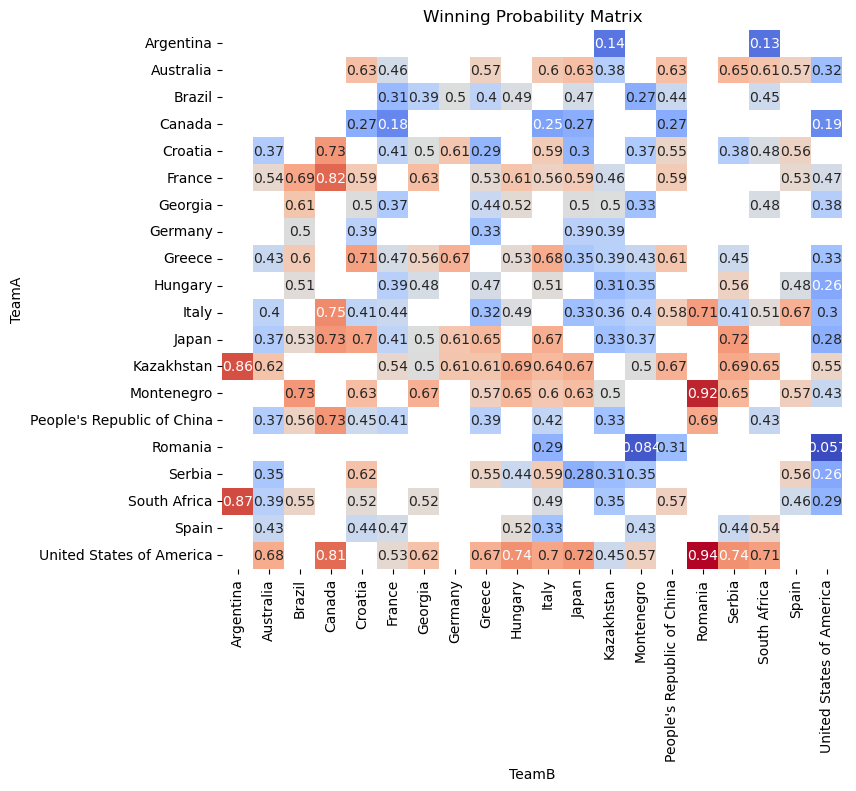

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

probs_matrix = pd.pivot_table(probs, values='Prob', index='TeamA', columns='TeamB')
plt.figure(figsize=(8, 7))
sns.heatmap(probs_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Winning Probability Matrix')
plt.show()



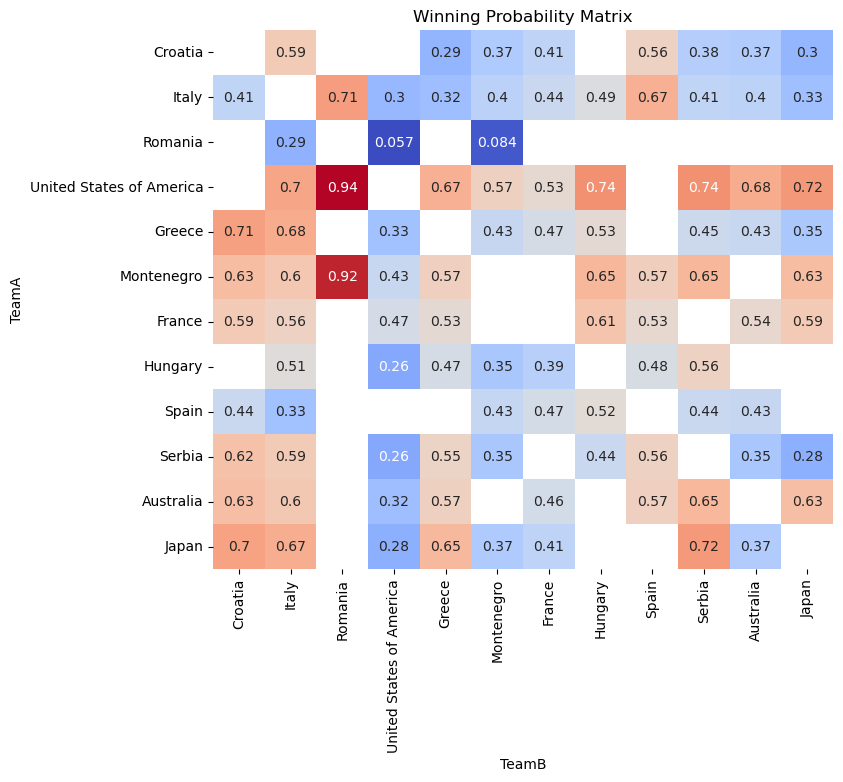

In [20]:
MENS_POOLS={'A':['Croatia','Italy','Romania','United States of America','Greece','Montenegro'],
            'B':['France','Hungary','Spain','Serbia','Australia','Japan']}

tams=MENS_POOLS['A']+MENS_POOLS['B']
probs_matrix = pd.pivot_table(probs, values='Prob', index='TeamA', columns='TeamB')
probs_matrix = probs_matrix.loc[tams,tams]
plt.figure(figsize=(8, 7))
sns.heatmap(probs_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Winning Probability Matrix')
plt.show()


In [27]:
import pandas as pd
import networkx as nx

G = nx.DiGraph()

for index, row in probs.iterrows():
    G.add_edge(row['TeamA'], row['TeamB'], prob=row['Prob'])

nx.write_gexf(G, 'graph.gexf')

In [35]:


eps=1e-12

l=0.0
r=1.0
while r-l>eps:
    m=(l+r)/2

    G = nx.DiGraph()
    for index, row in probs.iterrows():
        if row['Prob']>m:
            G.add_edge(row['TeamA'], row['TeamB'], prob=row['Prob'])
    
    if not nx.is_directed_acyclic_graph(G):
        l=m
    else:
        r=m

print(l)

0.5253691097259434


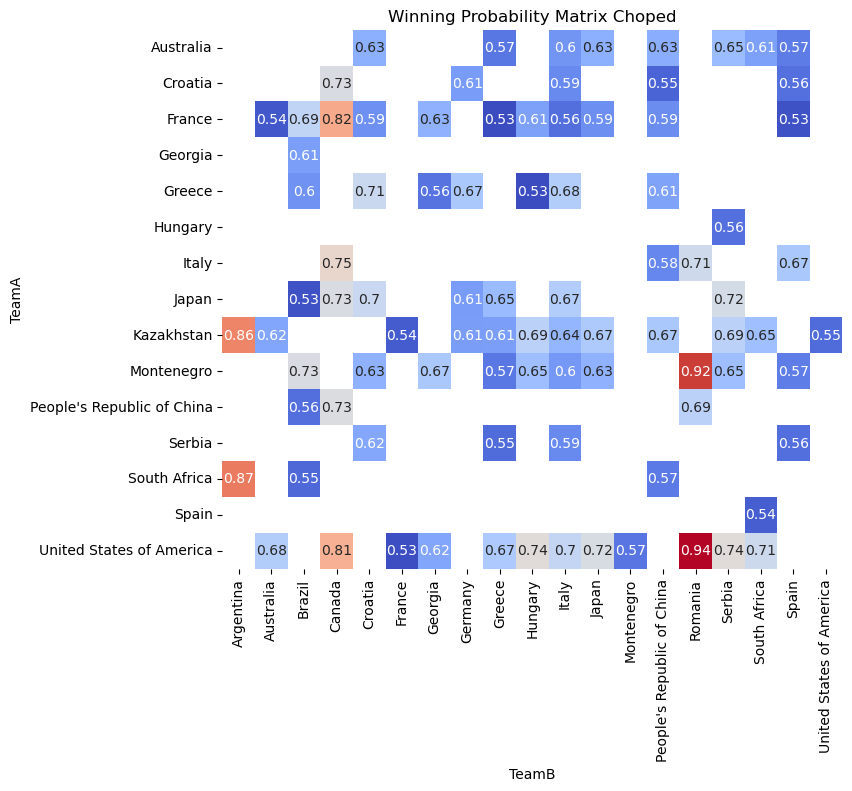

In [36]:
choped=probs[probs['Prob']>l]
probs_matrix = pd.pivot_table(choped, values='Prob', index='TeamA', columns='TeamB')
plt.figure(figsize=(8, 7))
sns.heatmap(probs_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Winning Probability Matrix Choped')
plt.show()


In [49]:
G = nx.DiGraph()
for index, row in choped.iterrows():
    G.add_edge(row['TeamA'], row['TeamB'], prob=row['Prob'])

RG=nx.reverse(G)
for u,v in RG.edges():
    RG[u][v]['prob']=1-RG[u][v]['prob']

def min_prob(u,v):
    nodes=set(G[u])
    nodes.intersection_update(set(nx.descendants(RG,v)))
    if len(nodes)==0:
        return -1
    mp=1.0
    for i in nodes:
        for j in nodes:
            if i!=j and G.has_edge(i,j):
                mp=min(mp,G[i][j]['prob'])
    return mp

for u in G.nodes():
    for v in G.nodes():
        if u!=v and not G.has_edge(u,v):
            mp=min_prob(u,v)
            if mp>0:
                G.add_edge(u,v,prob=mp)

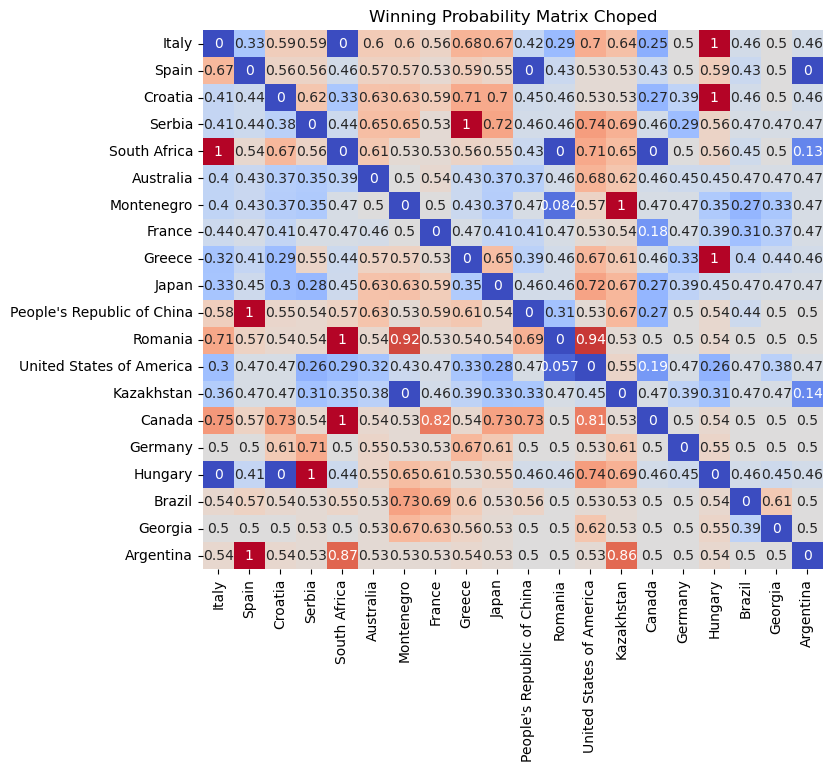

In [68]:
# Create matrix from G and print it 
probs_matrix = pd.DataFrame(index=G.nodes(),columns=G.nodes())
for u in G.nodes():
    for v in G.nodes():
        if u==v:
            probs_matrix[u][v]=0.0
        elif G.has_edge(u,v):
            probs_matrix[u][v]=G[u][v]['prob']
        else:
            pass
# fill the missing values with 1-probs[v][u]
for u in G.nodes():
    for v in G.nodes():
        if pd.isna(probs_matrix[u][v]):
            probs_matrix[u][v]=1-probs_matrix[v][u]

probs_matrix = probs_matrix.astype(float)

probs_matrix.fillna(0.5,inplace=True)

plt.figure(figsize=(8, 7))
sns.heatmap(probs_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Winning Probability Matrix Choped')
plt.show()

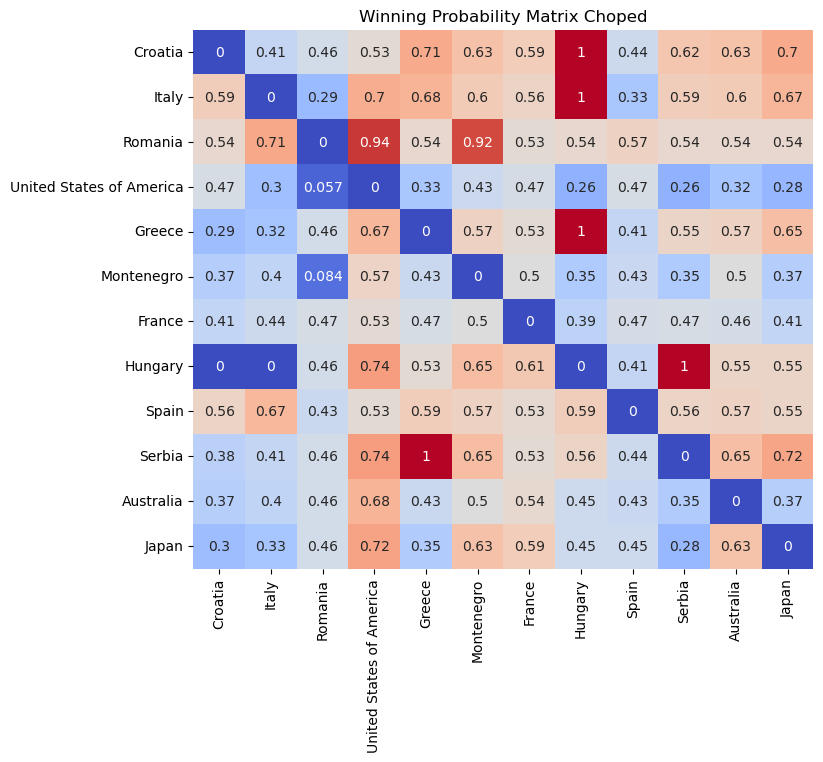

In [80]:
MENS_POOLS={'A':['Croatia','Italy','Romania','United States of America','Greece','Montenegro'],
            'B':['France','Hungary','Spain','Serbia','Australia','Japan']}

teams=MENS_POOLS['A']+MENS_POOLS['B']

probs_matrix = probs_matrix.loc[teams,teams]
plt.figure(figsize=(8, 7))
sns.heatmap(probs_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Winning Probability Matrix Choped')
plt.show()
df= probs_matrix

In [74]:
df

,Croatia,Italy,Romania,United States of America,Greece,Montenegro,France,Hungary,Spain,Serbia,Australia,Japan
Croatia,0.000000,0.412806,0.457457,0.525369,0.705465,0.633041,0.592388,1.000000,0.440311,0.619247,0.630468,0.703665
Italy,0.587194,0.000000,0.288569,0.697227,0.676643,0.601140,0.559412,1.000000,0.333304,0.586929,0.598485,0.674749
Romania,0.542543,0.711431,0.000000,0.943162,0.542543,0.915686,0.525369,0.542543,0.569763,0.542543,0.542543,0.542543
United States of America,0.474631,0.302773,0.056838,0.000000,0.331177,0.433846,0.471590,0.259977,0.474631,0.260345,0.323054,0.275234
Greece,0.294535,0.323357,0.457457,0.668823,0.000000,0.569290,0.526852,1.000000,0.412806,0.554784,0.566575,0.645308
Montenegro,0.366959,0.398860,0.084314,0.566154,0.430710,0.000000,0.500000,0.349287,0.426111,0.349722,0.500000,0.367184
France,0.407612,0.440588,0.474631,0.528410,0.473148,0.500000,0.000000,0.389186,0.468468,0.474631,0.463958,0.407847
Hungary,0.000000,0.000000,0.457457,0.740023,0.525369,0.650713,0.610814,0.000000,0.413071,1.000000,0.554784,0.554784
Spain,0.559689,0.666696,0.430237,0.525369,0.587194,0.573889,0.531532,0.586929,0.000000,0.559419,0.571182,0.554784
Serbia,0.380753,0.413071,0.457457,0.739655,1.000000,0.650278,0.525369,0.559651,0.440581,0.000000,0.647759,0.719057


In [81]:
# Convert in a DF with 3 columns Team1 Team2 and Probs remember that now is a matrix with each collumn being one Team
probs = pd.DataFrame(columns=['Team1','Team2','Prob'])
for i in range(len(teams)):
    for j in range(i+1,len(teams)):
        team1 = teams[i]
        team2 = teams[j]
        prob = df[team1][team2]
        probs = probs.append({'Team1':team1,'Team2':team2,'Prob':prob},ignore_index=True)
        probs = probs.append({'Team1':team2,'Team2':team1,'Prob':1-prob},ignore_index=True)

df=probs

C:\Users\leona\AppData\Local\Temp\ipykernel_7676\2823348983.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append({'Team1':team1,'Team2':team2,'Prob':prob},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7676\2823348983.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append({'Team1':team2,'Team2':team1,'Prob':1-prob},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7676\2823348983.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append({'Team1':team1,'Team2':team2,'Prob':prob},ignore_index=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_7676\2823348983.py:9: FutureWarning: The frame.append method is deprecated and will be removed from panda

In [82]:
gamesA = df[((df['Team1']=='Croatia') & (df['Team2']=='Georgia'))|((df['Team1']=='Georgia') & (df['Team2']=='Croatia'))]
gamesA

,Team1,Team2,Prob


In [83]:
gamesA = df[((df['Team1']=='South Africa') & (df['Team2']=='Argentina'))|((df['Team1']=='Argentina') & (df['Team2']=='South Africa'))]
gamesA

,Team1,Team2,Prob


# SVD (deprecated)

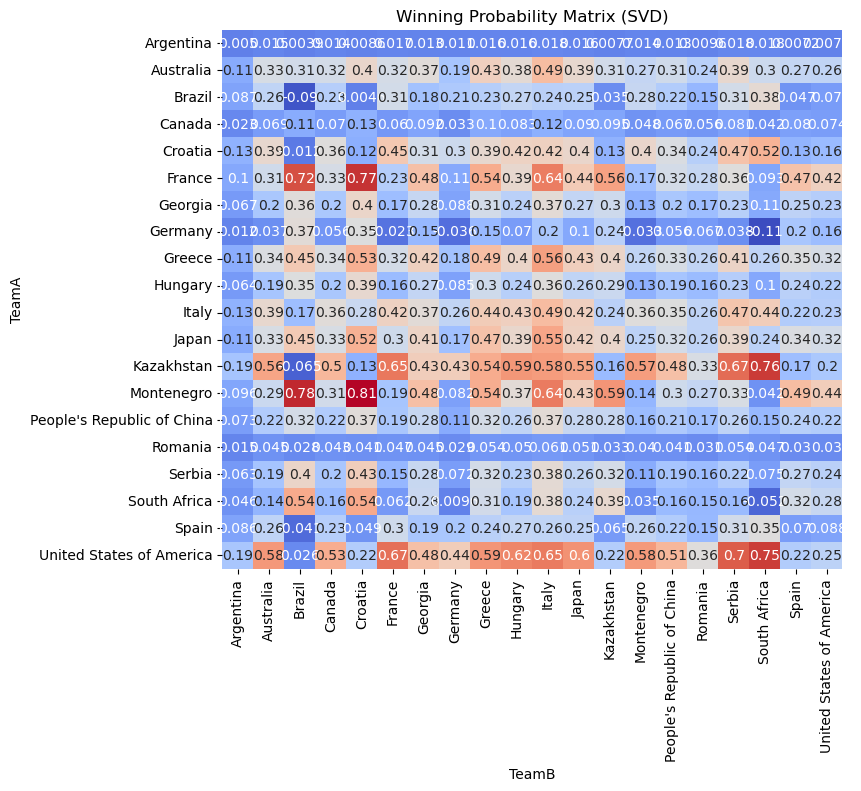

In [15]:
# from scipy.sparse.linalg import svds
# from scipy.sparse import csc_matrix

# probs_matrix = pd.pivot_table(probs, values='Prob', index='TeamA', columns='TeamB')
# probs_matrix = probs_matrix.fillna(0)
# U, S, Vt = svds(csc_matrix(probs_matrix), k=2)
# S = np.diag(S)
# probs_matrix_svd = np.dot(np.dot(U, S), Vt)
# probs_matrix_svd = pd.DataFrame(probs_matrix_svd, index=probs_matrix.index, columns=probs_matrix.columns)

# plt.figure(figsize=(8, 7))
# sns.heatmap(probs_matrix_svd, annot=True, cmap='coolwarm', cbar=False)
# plt.title('Winning Probability Matrix (SVD)')
# plt.show()

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

G = nx.Graph()

won={}
los={}

for i in range(len(df)):
    team1, team2 = team_split(df['Countries'][i])
    score1, score2 = score_split(df['Final Score'][i])

    won[team1]=won.get(team1,0)+int(score1>score2)
    los[team1]=los.get(team1,0)+int(score1<score2)
    
    if team1 not in G.nodes:
        G.add_node(team1)
    if team2 not in G.nodes:
        G.add_node(team2)
    
    if G.has_edge(team1, team2):
        G[team1][team2]['weight'] += 1
    else:
        G.add_edge(team1, team2, weight=1)  

nx.write_gexf(G, 'water_polo_results_selenium.gexf')



In [17]:
print(won)
print(los)

{'Spain': 5, 'Italy': 2, 'Croatia': 2, 'Greece': 4, 'Serbia': 3, 'Hungary': 4, 'South Africa': 5, 'Japan': 3, 'Brazil': 3, "People's Republic of China": 4, 'Australia': 5, 'Romania': 1, 'Montenegro': 6, 'United States of America': 1, 'France': 3, 'Kazakhstan': 5, 'Argentina': 0, 'Canada': 2, 'Germany': 0, 'Georgia': 4}
{'Spain': 3, 'Italy': 8, 'Croatia': 4, 'Greece': 12, 'Serbia': 4, 'Hungary': 4, 'South Africa': 1, 'Japan': 6, 'Brazil': 3, "People's Republic of China": 2, 'Australia': 5, 'Romania': 1, 'Montenegro': 7, 'United States of America': 10, 'France': 3, 'Kazakhstan': 5, 'Argentina': 1, 'Canada': 1, 'Germany': 2, 'Georgia': 2}


In [18]:
# Real Data
MENS_POOLS={'A':['Croatia','Italy','Romania','United States of America','Greece','Montenegro'],
            'B':['France','Hungary','Spain','Serbia','Australia','Japan']}


In [88]:
def simulate_match(team1, team2, probs_matrix):
    prob_team1_wins = probs_matrix.loc[team1, team2]
    return team1 if np.random.random() < prob_team1_wins else team2
    
def simulate_group_stage(teams, probs_matrix):
    points = {team: 0 for team in teams}
    for i, team1 in enumerate(teams):
        for j, team2 in enumerate(teams):
            if i < j:
                winner = simulate_match(team1, team2, probs_matrix)
                points[winner] += 2
    return points

def rank_teams(points):
    return sorted(points.items(), key=lambda x: (-x[1], x[0]))

def simulate_knockout_stage(teams, probs_matrix):
    winners = []
    for i in range(0, len(teams), 2):
        winner = simulate_match(teams[i], teams[i+1], probs_matrix)
        winners.append(winner)
    return winners

def simulate_tournament(MENS_POOLS, probs_matrix):
    group_results = {}
    for group, teams in MENS_POOLS.items():
        points = simulate_group_stage(teams, probs_matrix)
        ranked_teams = rank_teams(points)
        group_results[group] = [team for team, _ in ranked_teams]
    
    quarter_finalists_A = group_results['A'][:4]
    quarter_finalists_B = group_results['B'][:4]

    # Cuartos de final cruzados
    quarter_finals = [
        (quarter_finalists_A[0], quarter_finalists_B[3]),
        (quarter_finalists_A[1], quarter_finalists_B[2]),
        (quarter_finalists_A[2], quarter_finalists_B[1]),
        (quarter_finalists_A[3], quarter_finalists_B[0]),
    ]
    
    quarter_final_winners = []
    for match in quarter_finals:
        winner = simulate_match(match[0], match[1], probs_matrix)
        quarter_final_winners.append(winner)
    
    # Semifinales
    semi_finals = [
        (quarter_final_winners[0], quarter_final_winners[1]),
        (quarter_final_winners[2], quarter_final_winners[3]),
    ]
    
    semi_final_winners = []
    semi_final_losers = []
    for match in semi_finals:
        winner = simulate_match(match[0], match[1], probs_matrix)
        loser = match[0] if winner == match[1] else match[1]
        semi_final_winners.append(winner)
        semi_final_losers.append(loser)
    
    # Final
    gold_medal_winner = simulate_match(semi_final_winners[0], semi_final_winners[1], probs_matrix)
    silver_medal_winner = semi_final_winners[1] if gold_medal_winner == semi_final_winners[0] else semi_final_winners[0]
    
    # Partido por el bronce
    bronze_medal_winner = simulate_match(semi_final_losers[0], semi_final_losers[1], probs_matrix)
    
    return {
        'gold': gold_medal_winner,
        'silver': silver_medal_winner,
        'bronze': bronze_medal_winner
    }
# Simulate 100 tournaments
results = []
for i in range(1000):
    results.append(simulate_tournament(MENS_POOLS, probs_matrix))

# Calculate the number of times each team wins a medal
medals = {}
for result in results:
    for medal, team in result.items():
        if team not in medals:
            medals[team] = {'gold': 0, 'silver': 0, 'bronze': 0}
        medals[team][medal] += 1

# Print the results
for team, medal_counts in medals.items():
    print(f"{team}: {medal_counts}")


Spain: {'gold': 112, 'silver': 87, 'bronze': 82}
Italy: {'gold': 159, 'silver': 148, 'bronze': 163}
France: {'gold': 58, 'silver': 72, 'bronze': 71}
Croatia: {'gold': 183, 'silver': 149, 'bronze': 148}
Japan: {'gold': 46, 'silver': 49, 'bronze': 68}
Greece: {'gold': 101, 'silver': 114, 'bronze': 118}
Romania: {'gold': 161, 'silver': 138, 'bronze': 110}
Hungary: {'gold': 16, 'silver': 46, 'bronze': 32}
Australia: {'gold': 68, 'silver': 75, 'bronze': 84}
Montenegro: {'gold': 17, 'silver': 38, 'bronze': 48}
Serbia: {'gold': 73, 'silver': 64, 'bronze': 64}
United States of America: {'gold': 6, 'silver': 20, 'bronze': 12}
